# Clean triplet loss
## Plan
1. Data & preprocessing:
    - Load entire python dataset
    - Tokenize
    - Select 500 developers
    - Align tokens to `1x600` dimensionality
2. Model:
    - Layers:
        - Embedding
        - Connect embeddings
        - Conv2D
        - Conv2D
        - Max-column 2D Pooling
        - Conv1D
        - Dense (?)
    - Training:
        - triplet loss (3 types)
            - random
            - hard
            - semi-hard
3. Analysis:
    - precision and accuracy curves during training
    - PCA and T-SNE for visualization

In [4]:
import tqdm
import itertools

import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from tensorflow.keras import layers, regularizers, callbacks, optimizers, models

## 1. Data

In [2]:
df = pd.read_csv("py_df.csv")
df = df.drop(columns=["round", "task", "solution", "file", "full_path", "Unnamed: 0.1", "Unnamed: 0", "lang"])

In [3]:
df["n_lines"] = df.flines.apply(lambda x: str(x).count("\n"))
df["n_lines"].describe()

count    155359.000000
mean         50.815852
std          70.495160
min           0.000000
25%          27.000000
50%          41.000000
75%          62.000000
max       10052.000000
Name: n_lines, dtype: float64

In [4]:
df = df[(df.n_lines>0)]#&(df.n_lines<=120)]
df.n_lines.describe()

count    155330.000000
mean         50.825340
std          70.498321
min           1.000000
25%          27.000000
50%          41.000000
75%          62.000000
max       10052.000000
Name: n_lines, dtype: float64

## 2. Preprocessing

In [5]:
sp = spm.SentencePieceProcessor(model_file='embd/sentencepiece_bpe.model')
df.index = np.arange(len(df))
df["n_tokens"] = df.flines.apply(lambda x: len(sp.encode(x)))
df.describe()

,year,n_lines,n_tokens
count,155330.000000,155330.000000,155330.000000
mean,2013.619855,50.825340,343.410333
std,2.254751,70.498321,664.640139
min,2008.000000,1.000000,0.000000
25%,2012.000000,27.000000,172.000000
50%,2014.000000,41.000000,258.000000
75%,2016.000000,62.000000,396.000000
max,2016.000000,10052.000000,36488.000000


In [6]:
df = df[df.n_tokens<=500]
df.describe()

,year,n_lines,n_tokens
count,131932.000000,131932.000000,131932.000000
mean,2013.688969,39.105660,246.269737
std,2.234988,18.583861,107.445252
min,2008.000000,1.000000,0.000000
25%,2012.000000,25.000000,160.000000
50%,2014.000000,36.000000,230.000000
75%,2016.000000,51.000000,321.000000
max,2016.000000,380.000000,500.000000


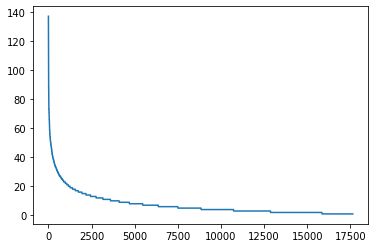

In [7]:
plt.plot(np.array(df.username.value_counts()))

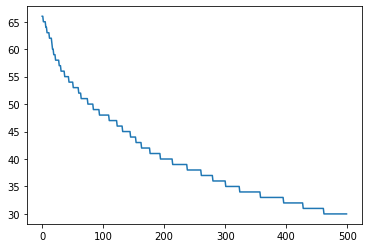

In [8]:
plt.plot(np.array(df.username.value_counts())[50:550])

In [9]:
users = df.username.value_counts()[50:550].index
df = df[df.username.isin(users)]
df.head()

,year,username,flines,n_lines,n_tokens
11,2008,Keegan,#!/usr/bin/env python\n \n import sys\n \n rea...,35,191
26,2008,eMBe,#!/usr/bin/python\n \n import sys\n from colle...,24,192
27,2008,Edu,#!/usr/bin/env python\n \n import sys\n \n def...,31,239
49,2008,Klinck,import sys\n import math\n \n cnt = [0]*1024\n...,57,321
50,2008,ipknHama,"n = input()\n for loop in range(1, n+1):\n \t\...",43,321


In [10]:
df.username.value_counts().describe()

count    500.000000
mean      40.260000
std        8.871404
min       30.000000
25%       33.000000
50%       38.000000
75%       46.000000
max       66.000000
Name: username, dtype: float64

In [11]:
df["tokens"] = df.flines.apply(lambda x: sp.encode(x))

In [12]:
dataset = df[["username", "tokens"]]

In [13]:
le = LabelEncoder()
dataset.username = le.fit_transform(dataset.username)

C:\Users\admin\SourceCodeAuthorshipAttribution\venv\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [14]:
# shuffle dataset
dataset = dataset.sample(frac = 1) 
dataset

,username,tokens
30907,53,"[3238, 2785, 96124, 1239, 96124, 1119, 96124, ..."
121668,18,"[138, 1149, 46, 1739, 1770, 264, 654, 63, 398,..."
77734,167,"[3074, 594, 2785, 96124, 1119, 96124, 1376, 18..."
121772,366,"[138, 2684, 156, 5045, 138, 14265, 96085, 3163..."
17599,339,"[63, 29, 96091, 96075, 45, 85, 49, 239, 1757, ..."
...,...,...
4328,254,"[63, 77046, 96091, 1613, 45, 274, 1613, 14, 24..."
10129,41,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
131637,86,"[1284, 1284, 4208, 96139, 13070, 63681, 46229,..."
48430,435,"[3238, 2785, 96124, 1119, 96124, 1796, 183, 42..."


In [15]:
def rsh(x):
    arr = np.array(x)
    arr.resize(500)
    return list(arr)

dataset.tokens = dataset.tokens.apply(rsh)

In [16]:
dataset.to_json("train.json")

## 2. Model

In [5]:
dataset = pd.read_json("train.json")

X = dataset.tokens.values
X = np.array(list(X)).reshape((-1, 500))

y = np.array(dataset.username)

def crop_to(X, y, crop=100, threshold=80):
    new_X = []
    new_y = []
    for old_x, old_y in zip(X, y):
        for el in old_x.reshape(-1, crop):
            if(np.count_nonzero(el) > 80):
                new_X.append(list(el))
                new_y.append(old_y)
    
    new_X = np.array(new_X).reshape(-1, crop, 1)
    new_y = np.array(new_y)
    return new_X, new_y

# X, y = crop_to(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(15097, 500)

In [6]:
X.max(), X.min()

(99756.0, 0.0)

In [7]:
# X = X[np.where(np.argmax(y, axis=1) < 40)]
# y = y[np.where(np.argmax(y, axis=1) < 40)]


In [8]:
max_val = int(X.max()) + 1
output_size = 50
input_size = 500

In [9]:
def batch_generator(X, y):
    
    data_length = X.shape[0]
    index = np.random.randint(data_length)
    anchor, anchor_y = X[index], y[index]
    
    positive = X[np.random.choice(np.where(y==anchor_y)[0])]
    negative = X[np.random.choice(np.where(y!=anchor_y)[0])]
    
    return [list(anchor), list(positive), list(negative)]

def batches_generator(X, y, batch_size=32):
    '''
    Array of batch_generator results
    
    batch_size - size of the generated array
    '''
    all_data = np.array([batch_generator(X, y) for i in range(batch_size)])
    anchors = all_data[:, 0, :]
    positives = all_data[:, 1, :]
    negatives = all_data[:, 2, :]
    return anchors, positives, negatives

def data_generator(X, y, batch_size=32, input_size=600):
    while True:
        batch = batches_generator(X, y, batch_size)
        labels = np.zeros((batch_size, input_size*3)) 
        yield batch, labels
        

In [10]:
def triplet_loss(y_true, y_pred):
    alpha = 0.2
    y_pred = tf.convert_to_tensor(y_pred)
    global output_size

    anchor = y_pred[:, :output_size]
    positive = y_pred[:, output_size:2*output_size]
    negative = y_pred[:, 2*output_size:]
    
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [11]:
def create_triplet_model(input_size, model_core):
    
    input_anchor = layers.Input(shape=(input_size))
    input_positive = layers.Input(shape=(input_size))
    input_negative = layers.Input(shape=(input_size))

    model_anchor = model_core(input_anchor)
    model_positive = model_core(input_positive)
    model_negative = model_core(input_negative)

    result = layers.concatenate([model_anchor, model_positive, model_negative], axis=1)
    model = models.Model([input_anchor, input_positive, input_negative], result)
    return model



In [65]:
def create_model(activation="linear", L2_lambda=0.02, 
                 pool_1_size=32, pool_2_size=8, 
                 conv_1_size=64, conv_2_size=16, conv_3_size=4, 
                 output_size=50, input_size=500):
    
    emb_heigh = 10
    
    model_core = keras.Sequential()
    model_core.add(layers.Embedding(max_val, emb_heigh, mask_zero=True, input_length=input_size))
    model_core.add(layers.Reshape((input_size, emb_heigh, 1)))
#     model_core.add(layers.Dropout(0.5))


    model_core.add(layers.Conv2D(16, (conv_1_size, emb_heigh), padding="same",
                                 activation=activation, 
                                 input_shape=(1, input_size, emb_heigh), data_format="channels_last"))
    
    model_core.add(layers.Conv2D(16, (conv_2_size, emb_heigh), 
                                 activation=activation, padding="same",
                                 input_shape=(1, input_size, emb_heigh), data_format="channels_last"))
    
    model_core.add(layers.MaxPooling2D(pool_size=(input_size, 1), data_format="channels_last"))
    model_core.add(layers.Reshape((-1, emb_heigh*16)))

       
#     model_core.add(layers.Dropout(0.5))
#     model_core.add(layers.Conv1D(16, conv_3_size,
#                                  padding="same",
#                                  activation=activation, 
#                                  kernel_regularizer=regularizers.L2(L2_lambda)))
#     model_core.add(layers.MaxPooling1D(pool_size=(pool_2_size), data_format="channels_last"))

                   
    model_core.add(layers.Flatten())
#     model_core.add(layers.Dropout(0.5))
                   
#     model_core.add(layers.Dense(dense_1, activation=activation, 
#                                 kernel_regularizer=regularizers.L2(L2_lambda)))
#     model_core.add(layers.LayerNormalization(axis=1))
    
    model_core.add(layers.Dropout(0.5))
    model_core.add(layers.Dense(output_size))
    return model_core


In [66]:
class TestCallback(callbacks.Callback):
    def __init__(self, X, y, emb_model, threshold=0.2, input_size=500):
        self.threshold = threshold
        self.input_size = input_size
        index = np.where(y<5)[0]
        self.X = X[index]
        self.y = y[index]
        self.scores = []
        self.recalls = []
        
    def _recreate_model(self):
        local_model = create_model()
        local_model.set_weights(self.model.layers[3].get_weights())
        return local_model
        
    def on_epoch_end(self, epoch, logs=None):
        #(model, new_X, new_y, threshold=0.2, printing=0):
        local_model = self._recreate_model()
        transformed_X = local_model.predict(self.X.reshape(-1, self.input_size, 1))
    #     X_train, X_test, y_train, y_test = train_test_split(transformed_X, new_y)
        
        y_pred = []
        y_true = []
        for i in range(self.X.shape[0]):
            for j in range(i, self.X.shape[0]):
                if np.mean((transformed_X[i] - transformed_X[j])**2) <= self.threshold:
                    y_pred.append(1)
                else:
                    y_pred.append(0)

                if self.y[i] == self.y[j]:
                    y_true.append(1)
                else:
                    y_true.append(0)
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)

        score = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
#         if printing:
#             print(cm)
#             print("totoal predicted as 1:", sum(y_pred), 
#                   "\ntotoal real 1:", sum(y_true), 
#                   "\ntotal examples", y_true.shape)
            
        recall = cm[1][1]/sum(y_true)
        
        self.scores.append(score)
        self.recalls.append(recall)
        print("accuracy:", round(score, 4), "recall:", round(recall, 4))
        return score, recall
    
    def return_results(self):
        return {"scores": self.scores, "recalls": self.recalls}



In [67]:
model1 = create_model()

In [68]:
triplet = create_triplet_model(input_size, model1)

In [69]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 10)           997570    
_________________________________________________________________
reshape_10 (Reshape)         (None, 500, 10, 1)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 500, 10, 16)       10256     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 500, 10, 16)       40976     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 10, 16)         0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 1, 160)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 160)              

In [70]:
triplet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 50)           1056852     input_10[0][0]                   
                                                                 input_11[0][0]             

In [71]:
batch_size = 128
epochs = 100
steps_per_epoch = int(X_train.shape[0]/batch_size)

optimizer = optimizers.Adam(0.1)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='loss', actor=0.5, 
                                          patience=3, min_delta=0.000001, 
                                          verbouse=1)

early_stopping = callbacks.EarlyStopping(monitor="loss", min_delta = 0.0001, 
                                         patience=12, restore_best_weights=True)
tb = callbacks.TensorBoard(log_dir = "./tensor_board", histogram_freq=1)

test_cb = TestCallback(X_train.reshape((-1, 500)), y_train, model1)

triplet.compile(loss=triplet_loss, optimizer=optimizer)
    
history = triplet.fit(data_generator(X_train, y_train, batch_size, input_size),
                     steps_per_epoch=steps_per_epoch,
                     epochs=epochs, 
                     verbose=1,
                     callbacks=[lr_schedule, early_stopping, tb, test_cb])

Epoch 1/100
117/117 [==============================] - 2284s 20s/step - loss: 744988.8907
accuracy: 0.473 recall: 0.6297
Epoch 2/100
117/117 [==============================] - 2200s 19s/step - loss: 20088165.4105
accuracy: 0.2668 recall: 0.9035
Epoch 3/100
117/117 [==============================] - 2235s 19s/step - loss: 51112810.4661
accuracy: 0.2588 recall: 0.9218
Epoch 4/100
117/117 [==============================] - 2236s 19s/step - loss: 70352857.3898
accuracy: 0.2299 recall: 0.9668
Epoch 5/100
117/117 [==============================] - 2232s 19s/step - loss: 171039054.2373
accuracy: 0.2299 recall: 0.9668
Epoch 6/100
117/117 [==============================] - 2271s 19s/step - loss: 15182563.2627
accuracy: 0.2299 recall: 0.9668
Epoch 7/100
117/117 [==============================] - 2252s 19s/step - loss: 9581640.6144
accuracy: 0.2299 recall: 0.9668
Epoch 8/100
117/117 [==============================] - 2250s 19s/step - loss: 8156448.4449
accuracy: 0.2299 recall: 0.9668
Epoch 9/100


## 3. Show the results

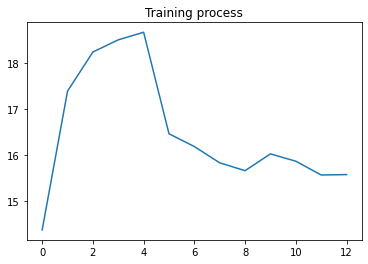

In [72]:
plt.title("Training process")
plt.plot(np.log(history.history["loss"]))

In [73]:
vectorized_x = model1.predict(X_train)

In [74]:
pca = PCA(n_components = 3)

In [75]:
x_pca = pca.fit_transform(vectorized_x)

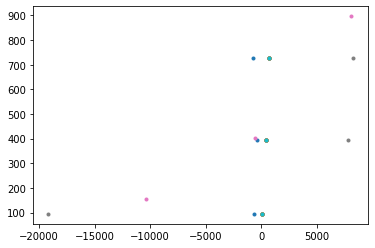

In [85]:
for developer in range(10):
    indexes = np.where(y_train==developer)
    plt.plot(x_pca[indexes][0], x_pca[indexes][1], "o", ms=3)

In [77]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 10)           997570    
_________________________________________________________________
reshape_10 (Reshape)         (None, 500, 10, 1)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 500, 10, 16)       10256     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 500, 10, 16)       40976     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 10, 16)         0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 1, 160)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 160)              

In [ ]:
model.save("")